<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INF6804 Vision par ordinateur

**Polytechnique Montréal**  
**Auteur :** Khalil Sabri  

**Description :** Ce Jupyter notebook présente un exemple d'utilisation de modèles de détection d'objets (YOLOX, Faster R-CNN, CenterNet, Mask R-CNN). Il est divisé en cinq parties :

1. **Installation de MMDetection**
2. **Téléchargement du dataset :** Utilisation du dataset réduit coco2017mini pour tester les modèles.
3. **Configuration des modèles et téléchargement des poids :** Les chemins de configuration et les liens vers les poids des modèles sont définis. Vous pouvez facilement tester d'autres modèles en ajoutant leurs liens et fichiers de configuration de la même manière.
4. **Chargement des modèles :** Les modèles sont initialisés sur l'appareil disponible (GPU ou CPU).
5. **Inférence et visualisation :** Inférence sur des images aléatoires du dataset et visualisation des résultats avec boîtes englobantes et classes.


## 1. Install MMSegmentation

Assurez-vous de sélectionner Cuda ! Le Colab pourrait vous demander, après l'installation de Pytorch, de relancer le notebook. Acceptez et relancez les premières cellules, mais ne réinstallez pas Pytorch car cela est déjà fait. Continuez à exécuter le reste du notebook.

Make sure you select Cuda ! The Colab might ask you after installing Pytorch to rerun the colab, accept and re-run the first cells, but do not re-run pytorch installation as it`s already done. Continue running the rest.


In [1]:
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 832.0 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Success

In [1]:
# Install mim
!pip install openmim
# Install mmengine
!pip install --upgrade mmengine
# Install MMCV
!mim install "mmcv==2.0.0rc4"
!pip install ftfy
!pip install datasets

  Using cached mmengine-0.10.4-py3-none-any.whl.metadata (20 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.40.2-py3-none-any.whl.metadata (45 kB)
Using cached mmengine-0.10.4-py3-none-any.whl (451 kB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.40.2-py3-none-any.whl (254 kB)
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
  Using cached https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/mmcv-2.0.0rc4-cp310-cp310-manylinux1_x86_64.whl (44.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.9 MB/s eta 0:00:00
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 22.1 MB/s

In [2]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 16493, done.
remote: Total 16493 (delta 0), reused 0 (delta 0), pack-reused 16493 (from 1)
Receiving objects: 100% (16493/16493), 43.82 MiB | 13.07 MiB/s, done.
Resolving deltas: 100% (11491/11491), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)

True
1.12.0+cu113


In [4]:
import cv2
import os
import json
import random
import numpy as np

import mmcv
import mmengine
import matplotlib.pyplot as plt
import zipfile

In [5]:
from mmseg.apis import inference_model, init_model, show_result_pyplot

from datasets import load_dataset
from PIL import Image
import requests
import zipfile

## 2. Downloading small dataset to work with: camvid


In [6]:
HOME = os.getcwd()
print("HOME:", HOME)
# CamVid dataset URL
url = 'https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz'

# Download the tar file
output_tgz = 'camvid.tgz'
response = requests.get(url, stream=True)
with open(output_tgz, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

# Extract the downloaded tar file
os.system(f'tar -xzf {output_tgz}')

# Define the image directory and list the images
image_dir = './camvid/images'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

print(f"Total images downloaded: {len(image_files)}")


HOME: /content/mmsegmentation
Total images downloaded: 701


## 3. Configure the different Models and download their weights (FCN, Deeplabv3)

In [7]:
os.makedirs(f"{HOME}/configs", exist_ok=True)
os.makedirs(f"{HOME}/weights", exist_ok=True)

# Define models, their config paths, and weight URLs
models = {
     "FCN": {
        "config_path": f"{HOME}/configs/fcn/fcn-d6_r101b-d16_4xb2-80k_cityscapes-769x769.py",
        "weights_url": "https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_d6_r101b-d16_769x769_80k_cityscapes/fcn_d6_r101b-d16_769x769_80k_cityscapes_20210311_154527-c4d8bfbc.pth"
    },
    "Deeplabv3": {
        "config_path": f"{HOME}/configs/deeplabv3/deeplabv3_r101b-d8_4xb2-80k_cityscapes-769x769.py",
        "weights_url": "https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3/deeplabv3_r101b-d8_769x769_80k_cityscapes/deeplabv3_r101b-d8_769x769_80k_cityscapes_20201226_190843-9142ee57.pth"
    },
    "PSPNet": {
        "config_path": f"{HOME}/configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py",
        "weights_url": "https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth"
    }
}

# Download the model weights if not already downloaded
for model_name, model_info in models.items():
    weights_filename = os.path.basename(model_info["weights_url"])
    weights_path = os.path.join(HOME, 'weights', weights_filename)

    if not os.path.exists(weights_path):
        print(f"Downloading weights for {model_name}...")
        !wget -P {HOME}/weights -q {model_info["weights_url"]}
    else:
        print(f"Weights for {model_name} already downloaded.")

# List the downloaded weights to verify
!ls -lh {HOME}/weights


total 782M
-rw-r--r-- 1 root root 333M Nov  2  2021 deeplabv3_r101b-d8_769x769_80k_cityscapes_20201226_190843-9142ee57.pth
-rw-r--r-- 1 root root 262M Nov  2  2021 fcn_d6_r101b-d16_769x769_80k_cityscapes_20210311_154527-c4d8bfbc.pth
-rw-r--r-- 1 root root 188M Nov  2  2021 pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


## 4. Load the different models

In [8]:
def load_model(model_name):
    config_path = models[model_name]["config_path"]
    weights_path = f"{HOME}/weights/{os.path.basename(models[model_name]['weights_url'])}"
    model = init_model(config_path, weights_path, device='cuda:0')
    return model


In [9]:
# Load each segmentation model
fcn_model = load_model("FCN")
deeplabv3_model = load_model("Deeplabv3")
pspnet_model = load_model("PSPNet")

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /content/mmsegmentation/weights/fcn_d6_r101b-d16_769x769_80k_cityscapes_20210311_154527-c4d8bfbc.pth
Loads checkpoint by local backend from path: /content/mmsegmentation/weights/deeplabv3_r101b-d8_769x769_80k_cityscapes_20201226_190843-9142ee57.pth
Loads checkpoint by local backend from path: /content/mmsegmentation/weights/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


## 5. Inference of each model on the dataset camvid

In [10]:
def visualize_segmentation(model, image_path, output_path='result.jpg', opacity=0.5):

    # Perform inference
    result = inference_model(model, image_path)

    # Save and display the result
    show_result_pyplot(model, image_path, result, show=False, out_file=output_path, opacity=opacity)

    # Load the saved result image and display it using OpenCV
    result_img = cv2.imread(output_path)
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()


In [23]:
# Optionally set a seed for reproducible image selection
#random.seed(0)  # Comment this line to see results on different images and enjoy :)

# Select a random image
IMAGE_PATH = random.choice(image_files)

print(f"Selected image: {IMAGE_PATH}")

Selected image: ./camvid/images/Seq05VD_f02730.png


### 5.1 FCN

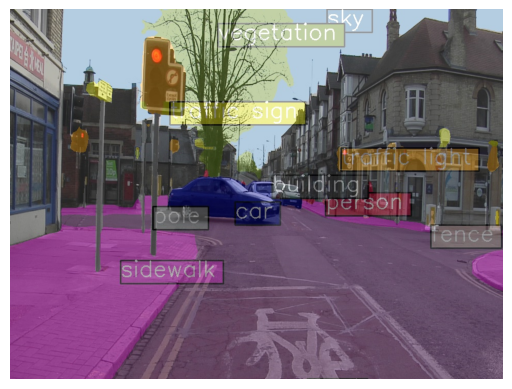

In [24]:
# Perform inference and visualize results using the fcn_model model
visualize_segmentation(fcn_model, IMAGE_PATH, output_path='fcn_random_result.jpg', opacity=0.4)

### 5.2 deeplabv3

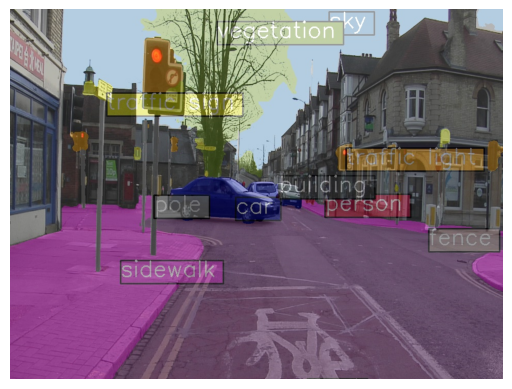

In [25]:
# Perform inference and visualize results using the deeplabv3 model
visualize_segmentation(deeplabv3_model, IMAGE_PATH, output_path='deeplabv3_random_result.jpg', opacity=0.4)

### 5.3 pspnet

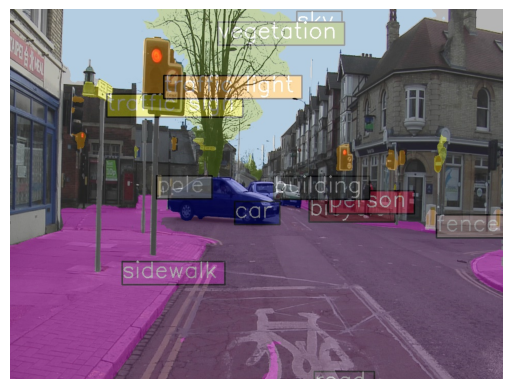

In [26]:
# Perform inference and visualize results using the pspnet_model model
visualize_segmentation(pspnet_model, IMAGE_PATH, output_path='pspnet_random_result.jpg', opacity=0.4)